# How to Build a Simple Video Summarizer App Using Aana SDK

In this notebook, we will demonstrate how to build the backend for an app that takes a video from YouTube, downloads it, and runs audio, video, and language models on it to generate a relevant summary. Additionally, you will be able to ask questions about the video from all modalities present, similar to the example shown below.

![Aana Demo](https://mobiusml.github.io/aana-sdk-introducing-blog/figs/aana_intro.gif)

The API will be accessible at `http://127.0.0.1:8005/video/chat_stream` and will stream out JSON objects.

## Installation

Aana is available on PyPI, so you can simply install it using pip. Alternatively, you can compile it using Poetry and easily containerize it. See more details at [Aana SDK GitHub](https://github.com/mobiusml/aana_sdk).

In [1]:
%pip install aana -qqqU 

Note: you may need to restart the kernel to use updated packages.


## Basic Building Blocks of Aana SDK

AanaSDK is the main class we will use to build our application. There are three main components in Aana SDK:

- **Deployments**: These are typically large machine learning models or heavy functions required for the application. They allow different parts of the application logic to call them without having to load them multiple times. Further, they can be deployed on a single machine or scaled across a cluster.
- **Endpoints**: This is where the application logic and functionality reside. Endpoints allow us to connect multiple deployments (models) to each other and define the input and output of the applications.
- **Main Class of Aana SDK**: This class allows us to deploy the deployments into clusters and endpoints, and to start and manage the application.

Note: AanaSDK is built on top of Ray and RayServe, which provides flexibility in scaling.

In [2]:
from aana.sdk import AanaSDK
aana_app = AanaSDK(name="chat_with_video_app")

/root/aana/aana_venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(
2024-07-12 07:48:44,207	WARNING api.py:432 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2024-07-12 07:48:44,245	WARNING api.py:432 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.


## Deployments
Deployments are the building blocks of Aana SDK. They represent the machine learning models that you want to deploy. Aana SDK comes with a set of predefined deployments that you can use or you can define your own deployments. For this demo, we will use a set of predefined deployments. See (https://github.com/mobiusml/aana_sdk/blob/main/docs/integrations.md) for the list of deployments already available.

Each deployment has a main class that defines it and a configuration class that allows you to specify the deployment parameters.

For this application, we will be using:
* Blip2 for extracting computer vision captions (https://huggingface.co/docs/transformers/main/en/model_doc/blip-2)
* Whisper for audio recognition (https://github.com/mobiusml/faster-whisper)
* InternLM for LLM, which is currently at the top of the LLM leaderboard for the 7B class of models (https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard)

Note, you will require a GPU(s) with 40GB of VRAM. We will use A6000s and is circa 0.60$ per hour in services like runpod and vast.ai 

In [3]:
from aana.configs.deployments import (
    hf_blip2_opt_2_7b_deployment,
    internlm2_5_7b_chat_deployment,
    whisper_medium_deployment,
)

2024-07-12 07:48:46,974	WARNING api.py:432 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
/root/aana/aana_venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/root/aana/aana_venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_kwargs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
2024-07-12 07:48:47,509	WARNING api.py:432 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
2024-07-12 07:48:47,517	WARNING api.py:432 -- The default value for `max_ongoing_requests` has changed from 100 to 5 in Ray 2.32.0.
/root/aana/aana_venv/lib/python3.10/site-packa

In [4]:
asr_model_name = "whisper_medium"
captioning_model_name = "hf_blip2_opt_2_7b"
max_video_len = 60 * 20  # 20 minutes


deployments = [
    {
        "name": "asr_deployment",
        "instance": whisper_medium_deployment,
    },    
    {
        "name": "captioning_deployment",
        "instance": hf_blip2_opt_2_7b_deployment,
    },
    {
        "name": "llm_deployment",
        "instance": internlm2_5_7b_chat_deployment,
    },
]

for deployment in deployments:
    aana_app.register_deployment(
        name=deployment["name"],
        instance=deployment["instance"],
    )

In [5]:
from aana.integrations.external.yt_dlp import download_video
from aana.processors.video import extract_audio

## Application Logic

Endpoints define the functionality of your application. They allow you to connect multiple deployments (models) to each other and define the input and output of your application.

Each endpoint is defined as a class that inherits from the `Endpoint` class. The class has two main methods: `initialize` and `run`.

In this example, we will create two endpoints:
1. `IndexVideoEndpoint`: To get the output of computer vision models and automatic transcript models. The output will be stored in an object of the `IndexVideoOutput` class.
2. `VideoChatEndpoint`: Where you can ask questions about an indexed video.

### Other Nice Things 
1. Aana comes pre-built with some goodies (functions) to extract frames, audio, etc. It also comes with a set of predefined types for various data such as images, videos, etc., making it simpler to handle multimodal data and further processing on it.
2. Aana supports streaming, and the output of the endpoint will be streamed to the client as it is generated.

In [6]:
import json
from collections.abc import AsyncGenerator
from typing import TYPE_CHECKING, Annotated, TypedDict

from pydantic import Field

from aana.api.api_generation import Endpoint
from aana.core.models.asr import (
    AsrSegments,
    AsrTranscription,
    AsrTranscriptionInfo,
)
from aana.core.models.chat import Question, ChatDialog, ChatMessage
from aana.core.models.media import MediaId
from aana.core.models.sampling import SamplingParams
from aana.core.models.video import VideoInput, VideoMetadata, VideoParams
from aana.core.models.whisper import BatchedWhisperParams
from aana.deployments.aana_deployment_handle import AanaDeploymentHandle
from aana.exceptions.db import MediaIdAlreadyExistsException, UnfinishedVideoException
from aana.exceptions.io import VideoTooLongException
from aana.integrations.external.decord import generate_frames, get_video_duration
from aana.processors.remote import run_remote
from aana.processors.video import generate_combined_timeline
from aana.storage.models.video import Status
from aana.storage.services.video import (
    check_media_id_exist,
    get_video_status,
    load_video_captions,
    load_video_metadata,
    load_video_transcription,
    save_video,
    save_video_captions,
    save_video_transcription,
    update_video_status,
)

if TYPE_CHECKING:
    from aana.core.models.audio import Audio
    from aana.core.models.video import Video


class IndexVideoOutput(TypedDict):
    """The output of the transcribe video endpoint."""

    media_id: MediaId
    metadata: VideoMetadata
    transcription: AsrTranscription
    transcription_info: AsrTranscriptionInfo
    segments: AsrSegments

    captions: Annotated[list[str], Field(..., description="Captions")]
    timestamps: Annotated[
        list[float], Field(..., description="Timestamps for each caption in seconds")
    ]

    transcription_id: Annotated[int, Field(..., description="Transcription Id")]
    caption_ids: Annotated[list[int], Field(..., description="Caption Ids")]

class IndexVideoEndpoint(Endpoint):
    """Transcribe video in chunks endpoint."""

    async def initialize(self):
        """Initialize the endpoint."""
        self.asr_handle = await AanaDeploymentHandle.create("asr_deployment")
        self.captioning_handle = await AanaDeploymentHandle.create(
            "captioning_deployment"
        )
        await super().initialize()

    async def run(
        self,
        video: VideoInput,
        video_params: VideoParams,
        whisper_params: BatchedWhisperParams,       
    ) -> AsyncGenerator[IndexVideoOutput, None]:
        """Transcribe video in chunks."""
        media_id = video.media_id
        if check_media_id_exist(media_id):
            raise MediaIdAlreadyExistsException(table_name="media", media_id=video)

        video_obj: Video = await run_remote(download_video)(video_input=video)
        video_duration = await run_remote(get_video_duration)(video=video_obj)

        if video_duration > max_video_len:
            raise VideoTooLongException(
                video=video_obj,
                video_len=video_duration,
                max_len=max_video_len,
            )

        save_video(video=video_obj, duration=video_duration)
        yield {
            "media_id": media_id,
            "metadata": VideoMetadata(
                title=video_obj.title, description=video_obj.description
            ),
        }

        try:
            update_video_status(media_id=media_id, status=Status.RUNNING)
            audio: Audio = extract_audio(video=video_obj)


            transcription_list = []
            segments_list = []
            transcription_info_list = []
            async for whisper_output in self.asr_handle.transcribe_stream(
                audio=audio, params=whisper_params
            ):
                transcription_list.append(whisper_output["transcription"])
                segments_list.append(whisper_output["segments"])
                transcription_info_list.append(whisper_output["transcription_info"])
                yield {
                    "transcription": whisper_output["transcription"],
                    "segments": whisper_output["segments"],
                    "info": whisper_output["transcription_info"],
                }
            transcription = sum(transcription_list, AsrTranscription())
            segments = sum(segments_list, AsrSegments())
            transcription_info = sum(transcription_info_list, AsrTranscriptionInfo())

            captions = []
            timestamps = []
            frame_ids = []

            async for frames_dict in run_remote(generate_frames)(
                video=video_obj, params=video_params
            ):
                if len(frames_dict["frames"]) == 0:
                    break

                timestamps.extend(frames_dict["timestamps"])
                frame_ids.extend(frames_dict["frame_ids"])

                captioning_output = await self.captioning_handle.generate_batch(
                    images=frames_dict["frames"]
                )
                captions.extend(captioning_output["captions"])

                yield {
                    "captions": captioning_output["captions"],
                    "timestamps": frames_dict["timestamps"],
                }

            save_video_transcription_output = save_video_transcription(
                model_name=asr_model_name,
                media_id=video_obj.media_id,
                transcription=transcription,
                segments=segments,
                transcription_info=transcription_info,
            )

            save_video_captions_output = save_video_captions(
                model_name=captioning_model_name,
                media_id=video_obj.media_id,
                captions=captions,
                timestamps=timestamps,
                frame_ids=frame_ids,
            )

            yield {
                "transcription_id": save_video_transcription_output["transcription_id"],
                "caption_ids": save_video_captions_output["caption_ids"],
            }
        except BaseException:
            update_video_status(media_id=media_id, status=Status.FAILED)
            raise
        else:
            update_video_status(media_id=media_id, status=Status.COMPLETED)
            
            


def generate_dialog(
    metadata: VideoMetadata,
    timeline: str,
    question: Question,
) -> ChatDialog:
    """Generates a dialog from the metadata and timeline of a video.

    Args:
        metadata (VideoMetadata): the metadata of the video
        timeline (str): the timeline of the video
        question (Question): the question to ask

    Returns:
        ChatDialog: the generated dialog
    """
    system_prompt_preamble = """You are a helpful, respectful, and honest assistant. Always answer as helpfully as possible, while ensuring safety. You will be provided with a script in json format for a video containing information from visual captions and audio transcripts. Each entry in the script follows the format:

    {{
    "start_time":"start_time_in_seconds",
    "end_time": "end_time_in_seconds",
    "audio_transcript": "the_transcript_from_automatic_speech_recognition_system",
    "visual_caption": "the_caption_of_the_visuals_using_computer_vision_system"
    }}
    Note that the audio_transcript can sometimes be empty.

    Ensure you do not introduce any new named entities in your output and maintain the utmost factual accuracy in your responses.

    In the addition you will be provided with title of video extracted.
    """
    instruction = (
        "Provide a short and concise answer to the following user's question. "        
    )

    user_prompt_template = (
        "{instruction}"
        "Given the timeline of audio and visual activities in the video below "
        "I want to find out the following: {question}"
        "The timeline is: "
        "{timeline}"
        "\n"
        "The title of the video is {video_title}"
    )

    messages = []
    messages.append(ChatMessage(content=system_prompt_preamble, role="system"))
    messages.append(
        ChatMessage(
            content=user_prompt_template.format(
                instruction=instruction,
                question=question,
                timeline=timeline,
                video_title=metadata.title,
            ),
            role="user",
        )
    )

    dialog = ChatDialog(messages=messages)
    return dialog


class VideoChatEndpointOutput(TypedDict):
    """Video chat endpoint output."""
    completion: Annotated[str, Field(description="Generated text.")]


class VideoChatEndpoint(Endpoint):
    """Video chat endpoint."""

    async def initialize(self):
        """Initialize the endpoint."""
        self.llm_handle = await AanaDeploymentHandle.create("llm_deployment")
        await super().initialize()

    async def run(
        self, media_id: MediaId, question: Question, sampling_params: SamplingParams
    ) -> AsyncGenerator[VideoChatEndpointOutput, None]:
        """Run the video chat endpoint."""
        # check to see if video already processed
        video_status = get_video_status(media_id=media_id)
        if video_status != Status.COMPLETED:
            raise UnfinishedVideoException(
                media_id=media_id,
                status=video_status,
                message=f"The video data is not available, status: {video_status}",
            )

        load_video_transcription_output = load_video_transcription(
            media_id=media_id, model_name=asr_model_name
        )

        loaded_video_captions_output = load_video_captions(
            media_id=media_id, model_name=captioning_model_name
        )

        video_metadata = load_video_metadata(media_id=media_id)

        timeline_output = generate_combined_timeline(
            transcription_segments=load_video_transcription_output["segments"],
            captions=loaded_video_captions_output["captions"],
            caption_timestamps=loaded_video_captions_output["timestamps"],
        )
        timeline_json = json.dumps(
            timeline_output["timeline"], indent=4, separators=(",", ": ")
        )

        dialog = generate_dialog(
            metadata=video_metadata,
            timeline=timeline_json,
            question=question,
        )
        async for item in self.llm_handle.chat_stream(
            dialog=dialog, sampling_params=sampling_params
        ):
            yield {"completion": item["text"]}


In [7]:
endpoints = [
    {
        "name": "index_video_stream",
        "path": "/video/index_stream",
        "summary": "Index a video and return the captions and transcriptions as a stream",
        "endpoint_cls": IndexVideoEndpoint,
    },
    {
        "name": "video_chat_stream",
        "path": "/video/chat_stream",
        "summary": "Chat with video using LLaMa2 7B Chat (streaming)",
        "endpoint_cls": VideoChatEndpoint,
    },   
]

for endpoint in endpoints:
    aana_app.register_endpoint(
        name=endpoint["name"],
        path=endpoint["path"],
        summary=endpoint["summary"],
        endpoint_cls=endpoint["endpoint_cls"],
    )

## Let us spin-up the application! 
Another nice thing: Aana will automatically generate the documentation for the applicaiton based on our defined end points. 

In [8]:
aana_app.connect(host="127.0.0.1", port=8005, show_logs=False)  # Connects to the Ray cluster or starts a new one.
aana_app.migrate()                                              # Runs the migrations to create the database tables.
aana_app.deploy(blocking=False)

Deployed successfully.

Documentation is available at ]8;id=446120;http://127.0.0.1:8005/docs\http://127.0.0.1:8005/docs]8;;\ and ]8;id=679698;http://127.0.0.1:8005/redoc\http://127.0.0.1:8005/redoc]8;;\

## Viola! 

In [9]:
import json
import re
import requests
from datetime import datetime
url = "https://www.youtube.com/watch?v=GBVkDfXUSls&ab_channel=KeralaTourism"

match = re.search(r"v=([^&]+)", url)
video_id = match.group(1) if match else None
media_id = f"{video_id}_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

video = {
    "url": url,  # Video URL, Aana SDK supports URLs (including YouTube), file paths or even raw video data
    "media_id": media_id,  # Media ID, so we can ask questions about the video later by using this ID
}

data = {
    "video_params": {
        "fast_mode_enabled": True,  # Enable fast mode, which only processes keyframes
    },
    "video": video,
}

url = "http://127.0.0.1:8005/video/index_stream"
response = requests.post(url, data={"body": json.dumps(data)}, stream=True)

for chunk in response.iter_content(chunk_size=None):
    json_data = json.loads(chunk)
    if "error" in json_data:
        print(json_data["error"])
        print(json_data["message"])
        print(json_data["stacktrace"])
        break
    else:
        print(json_data)

{'media_id': 'GBVkDfXUSls_2024-07-12 07:49:51', 'metadata': {'title': "Appu's Big Friend | Kerala Tourism", 'description': 'It’s just another day for Appu and his big friend. But it’s an escape from the ordinary for you!', 'duration': None}}
{'transcription': {'text': ' ¡Dios, Dios, venga, venga!'}, 'segments': [{'text': ' ¡Dios, Dios, venga, venga!', 'time_interval': {'start': 0.0, 'end': 1.0}, 'confidence': 0.5342926200703176, 'no_speech_confidence': 0.1846923828125, 'words': []}], 'info': {'language': 'es', 'language_confidence': 0.469970703125}}
{'transcription': {'text': ' ¡Eh, chenille, ahí!'}, 'segments': [{'text': ' ¡Eh, chenille, ahí!', 'time_interval': {'start': 4.0, 'end': 5.0}, 'confidence': 0.5342926200703176, 'no_speech_confidence': 0.1846923828125, 'words': []}], 'info': {'language': 'es', 'language_confidence': 0.469970703125}}
{'transcription': {'text': ' ¡Ganesha!'}, 'segments': [{'text': ' ¡Ganesha!', 'time_interval': {'start': 7.0, 'end': 8.0}, 'confidence': 0.53429

In [10]:

question = (
    "What is happening in this video? "
    "Focus on highlighting the story, the narrative, emotionally and thematically significant aspects. "
    "Do not use bulleted list in your answer."
)

data = {
    "question": question,
    "media_id": media_id,
    "sampling_params": {
        "temperature": 0.9,
        "max_tokens": 1024,
    },
}

url = "http://127.0.0.1:8005/video/chat_stream"

response = requests.post(url, data={"body": json.dumps(data)}, stream=True)
op = ""
for chunk in response.iter_content(chunk_size=None):
    chunk_dict = json.loads(chunk)
    
    if "error" in chunk_dict:
        print(chunk_dict["error"])
        print(chunk_dict["message"])
        print(chunk_dict["stacktrace"])
        break
    token = chunk_dict["completion"]
    op += token
    print(token, end="")

This video appears to be a montage showcasing various activities related to Ganesha and his interactions with people, focusing on elements of culture and daily life in Kerala, India. The narrative revolves around the celebration or worship of Ganesha, a deity known for new beginnings and remover of obstacles. The themes include community, festivities, and the blend of nature and spirituality.

The video begins with an energetic chanting and visuals of people engaging with Ganesha images, indicating the start of a significant event or ritual. It progresses through scenes of nature, suggesting the purity or tranquility associated with Ganesha, leading to interactions involving an elephant and a bike ride that emphasizes the theme of integration of tradition and modernity.

The later segments showcase communal celebration with activities like playing soccer, playing music (like the chayas), and concluding with a family gathering that highlights personal connections and the enthusiastic sp

This video appears to be a montage showcasing various activities related to Ganesha and his interactions with 
people, focusing on elements of culture and daily life in Kerala, India. The narrative revolves around the 
celebration or worship of Ganesha, a deity known for new beginnings and remover of obstacles. The themes include 
community, festivities, and the blend of nature and spirituality.

The video begins with an energetic chanting and visuals of people engaging with Ganesha images, indicating the 
start of a significant event or ritual. It progresses through scenes of nature, suggesting the purity or 
tranquility associated with Ganesha, leading to interactions involving an elephant and a bike ride that emphasizes 
the theme of integration of tradition and modernity.

The later segments showcase communal celebration with activities like playing soccer, playing music (like the 
chayas), and concluding with a family gathering that highlights personal connections and the enthusiastic spirit 
the viewer is drawn into through social and familial interactions. The mention of a "cumper birthday" hints at 
festivities, possibly a birthday of an individual named Ikru, further showcasing the community aspect of the 
celebrations. The full engagement of the community in the festivities, including the participation of elephants in 
their traditional roles, underscores the cultural essence of the video.

The visual imagery, particularly the elephant scenes, highlights the respect and reverence towards Ganesha, his 
family, and the symbolic elements of purity and feast associated with rituals. The sequence of actions without 
verbal conversations, mainly involving the elephant's casual interactions with people, underscores the non-verbal 
form of communication and interaction that is a central element of the storyline. The video ends on a residential 
note, encapsulating the home environment presenting a sense of community and familial warmth. Overall, it seems to 
be highlighting the blend of religious devotion, community spirit, and the celebration of life in Kerala.

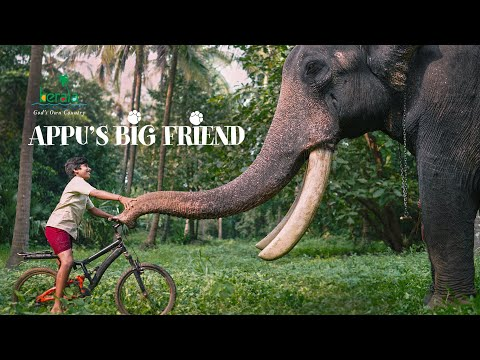

In [11]:
from IPython.display import YouTubeVideo
import rich
rich.print(op)
YouTubeVideo(video_id)
